In [32]:
#Desafio Técnico - Estágio em Meteorologia Ampere: Edivan Silva
!pip install pygrib cartopy #Para o exercicio_2

In [33]:
# EXERCICIO 1 - Download de Arquivos GRIB
import os
import requests

# Diretório no COLAB para salvar os arquivos baixados
download_dir = "MERGE_GRIBS"
os.makedirs(download_dir, exist_ok=True)

# URL do MERGE
base_url = "https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/03/"

# Datas a serem baixadas: De 15/03/2025 a 21/03/2025
dates = [f"202503{day:02d}" for day in range(15, 22)]

# Função para baixar os arquivos GRIB
def download_grib_files():
    for date in dates:
        file_name = f"MERGE_CPTEC_{date}.grib2"
        file_url = base_url + file_name
        file_path = os.path.join(download_dir, file_name)

        if not os.path.exists(file_path):
            response = requests.get(file_url)
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
                print(f"Baixado: {file_name}")
            else:
                print(f"Erro ao baixar {file_name}")

download_grib_files()



ConnectionError: HTTPSConnectionPool(host='ftp.cptec.inpe.br', port=443): Max retries exceeded with url: /modelos/tempo/MERGE/GPM/DAILY/2025/03/MERGE_CPTEC_20250315.grib2 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f7b7d9ab650>: Failed to resolve 'ftp.cptec.inpe.br' ([Errno -2] Name or service not known)"))

In [2]:
# EXERCICIO 2 - Acumulado de Chuva e Plotagem de Mapa

import pygrib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Lista de arquivos GRIB baixados:
grib_files = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith(".grib2")]

# Inicializa a matriz de precipitação acumulada:
total_precip = None
lats, lons = None, None

# Processamento cada arquivo GRIB para somar a precipitação:
for file in grib_files:
    grbs = pygrib.open(file)
    grb = grbs.select(name='Precipitation')[0]
    data = grb.values

    if total_precip is None:
        total_precip = np.zeros_like(data)

    total_precip += data
    lats, lons = grb.latlons()

# Intervalos de cores da precipitação:
levels = [0, 1, 10, 25, 50, 75, 100, 150, 200, 300]

# Paleta de cores:
colors = ["#FFFFFF", "#bfd6d6", "#7cafd1", "#206ecb", "#56d66e",
          "#15b403","#179817", "#d7c362","#d6a12f", "#d65200"]

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, cmap.N)

# Gerar o mapa:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adiciona contornos:
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces',
                                            scale='50m',
                                            facecolor='none',
                                            edgecolor='black', linewidth=0.6))  # Contorno dos estados do Brasil

ax.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())

# Plot da precipitação acumulada:
cs = ax.contourf(lons, lats, total_precip, levels=levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Adicionando coordenadas nos eixos X e Y:
ax.set_xticks(np.arange(-85, -30, 5), crs=ccrs.PlateCarree())  # Longitude
ax.set_yticks(np.arange(-55, 20, 5), crs=ccrs.PlateCarree())  # Latitude
ax.tick_params(labelsize=7)

# Adicionando barra de cores da legenda:
cbar = plt.colorbar(cs, ax=ax, orientation="horizontal", fraction=0.035, pad=0.05, ticks=levels)
cbar.set_label("Precipitação (mm)", fontsize=8)
cbar.ax.tick_params(labelsize=10, width=1.2)
cbar.outline.set_linewidth(1.2)

# Título do Mapa:
plt.title("PRECIPITAÇÃO OBSERVADA\nPeríodo: 15/03/2025 a 21/03/2025", fontsize=12, fontweight="bold", pad=8)

# Salvando imagem do mapa em PNG:
plt.savefig("Precip_Acumulada.png", dpi=300, bbox_inches="tight")
plt.show()



NameError: name 'os' is not defined

<ipython-input-53-6b128e4ec1ee>:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_precip_bacia = gdf_precip[gdf_precip.geometry.within(bacia_grande.geometry.unary_union)]


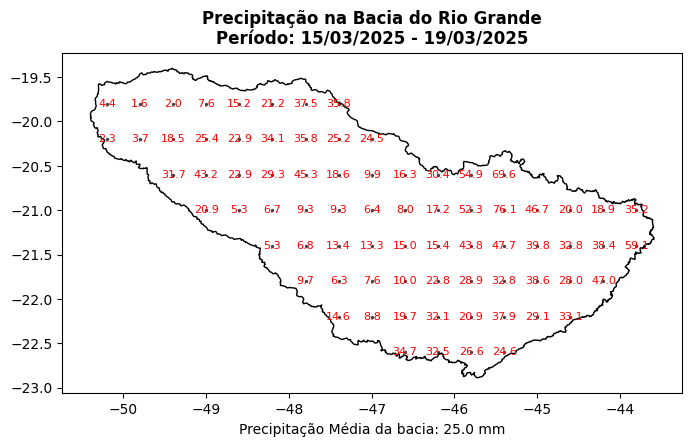

In [53]:
# EXERCICIO 3 - Extração de Valores de Precipitação da Bacia do Grande

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Diretórios e arquivos:
repo_dir = "/content/Desafio-Estagio-Meteorologia-Ampere"
dataset_dir = os.path.join(repo_dir, "exercicio-03/dataset")
data_file = os.path.join(dataset_dir, "MERGE_20250315-20250319.dat")
shapefile = os.path.join(dataset_dir, "GRANDE.shp")

# Clonar repositório com os arquivos:
if not os.path.exists(repo_dir):
    !git clone --depth 1 --filter=blob:none --sparse https://github.com/thalesteo1995/Desafio-Estagio-Meteorologia-Ampere.git {repo_dir}
    !cd {repo_dir} && git sparse-checkout set exercicio-03/dataset

# Carregar os dados:
df = pd.read_csv(data_file, sep='\s+', names=["longitude", "latitude", "precip"])
gdf_precip = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)], crs="EPSG:4326")
bacia_grande = gpd.read_file(shapefile)

# Filtrar os pontos dentro da bacia:
gdf_precip_bacia = gdf_precip[gdf_precip.geometry.within(bacia_grande.geometry.unary_union)]
media_precip_bacia = gdf_precip_bacia["precip"].mean()
gdf_precip_bacia.to_csv("Média_prec_bacia.csv", index=False) #Extraindo os dados dentro da bacia

# Gerar mapa:
fig, ax = plt.subplots(figsize=(8, 6))
bacia_grande.boundary.plot(ax=ax, color="black", linewidth=1) #Shape da Bacia
gdf_precip_bacia.plot(ax=ax, markersize=2, color="gray", alpha=0.7, edgecolor="black") #Pontos dentro da Bacia

for x, y, pr in zip(gdf_precip_bacia.geometry.x, gdf_precip_bacia.geometry.y, gdf_precip_bacia["precip"]):
    ax.text(x, y, f"{pr:.1f}", fontsize=8, ha="center", va="center", color="red", fontweight="light") # Valor da Prec.

# Titulo do Mapa:
plt.title("Precipitação na Bacia do Rio Grande\nPeríodo: 15/03/2025 - 19/03/2025", fontsize=12, fontweight="bold")

# Legenda da precipitação Média da Bacia:
plt.text(0.5, -0.12, f"Precipitação Média da bacia: {media_precip_bacia:.1f} mm",
         fontsize=10, ha="center", transform=ax.transAxes, fontweight="light")

# Removendo linhas de grade do mapa:
ax.grid(False)


plt.show()
